# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started. Once you have completed the code you can download the notebook for making a submission.

Import Required Libraries

In [6]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import os
import time

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU,LSTM, Dropout, Flatten,TimeDistributed, BatchNormalization, Activation, Conv3D, MaxPooling3D,Conv2D,MaxPooling2D,Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

We set the random seed so that the results don't vary drastically.

In [8]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

Tried with different batch sizes of 60 ,80 and 100 .Found batch size of 100 optimal for execution

In [9]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size =80

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [10]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29] # Chose 18 frames
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//batch_size
        
        for batch in range(num_batches): # we iterate over the number of batches
            #Tried image size of 128*128 ,100*100 ,80*80,found with image_size 64*64 the prediction accuracy is good
            batch_data = np.zeros((batch_size,len(img_idx),64,64,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape
                    #and the conv3D will throw error if the inputs in a batch have different shapes 
                    image = resize(image,(64,64)).astype(np.float32)
                    
                    #normalising using min/max normalization and feeding in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0])- np.min(image[:,:,0])) 
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1])- np.min(image[:,:,1])) 
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2])- np.min(image[:,:,2])) 
                                        
                #Prepare one hot encoded label vectors
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels

        
        # Handle remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,len(img_idx),64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                
                for idx,item in enumerate(img_idx):
                    image = imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)

                    #cropping the images and resizing them. Note that the images are of 2 different shape 
                    image = resize(image,(64,64)).astype(np.float32)
                   
                    #normalising using min/max normalization and feeding in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.min(image[:,:,0]))/(np.max(image[:,:,0])- np.min(image[:,:,0]))
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.min(image[:,:,1]))/(np.max(image[:,:,1])- np.min(image[:,:,1]))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.min(image[:,:,2]))/(np.max(image[:,:,2])- np.min(image[:,:,2]))

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [11]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'

num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)

num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## 3D Convolution Network

In [8]:
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
Input_shape = (18,64,64,3)

model = Sequential()
model.add(Conv3D(nb_featuremap[0], 
                 kernel_size=(5,5,5),
                 input_shape=Input_shape,
                 padding='same', name="conv1"))
model.add(Activation('relu'))
model.add(Conv3D(nb_featuremap[1], 
                 kernel_size=(3,3,3),
                 padding='same',name="conv2"))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Conv3D(nb_featuremap[2], 
                 kernel_size=(1,3,3), 
                 padding='same',name="conv3"))
model.add(Activation('relu'))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPooling3D(pool_size=(2,2,2)))
model.add(Flatten())
model.add(Dense(nb_dense[0], activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(nb_dense[1], activation='relu'))
#softmax layer
model.add(Dense(nb_dense[2], activation='softmax'))

2022-07-09 09:53:12.117563: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-09 09:53:12.117649: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [10]:
#Using adam optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 18, 64, 64, 8)     3008      
                                                                 
 activation (Activation)     (None, 18, 64, 64, 8)     0         
                                                                 
 conv2 (Conv3D)              (None, 18, 64, 64, 16)    3472      
                                                                 
 activation_1 (Activation)   (None, 18, 64, 64, 16)    0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 9, 32, 32, 16)    0         
 )                                                               
                                                                 
 conv3 (Conv3D)              (None, 9, 32, 32, 32)     4640      
                                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [12]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [13]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto',save_freq ='epoch')

LR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, mode='min', min_delta=0.0001, cooldown=0, min_lr=0.00001)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [14]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
start = time.time()

history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

end = time.time()

print("Total time taken for training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.3941 - categorical_accuracy: 0.4163
Epoch 00001: saving model to model_init_2022-07-0909_52_20.202759/model-00001-1.39409-0.41629-1.61071-0.22000.h5
9/9 [==============================] - 103s 13s/step - loss: 1.3941 - categorical_accuracy: 0.4163 - val_loss: 1.6107 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.2889 - categorical_accuracy: 0.4600
Epoch 00002: saving model to model_init_2022-07-0909_52_20.202759/model-00002-1.28892-0.46003-1.60137-0.23000.h5
9/9 [==============================] - 92s 11s/step - loss: 1.2889 - categorical_accuracy: 0.4600 - val_loss: 1.6014 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.2056 - categorical_accuracy: 0.5204
Epoch 00003: saving model to model_init_2022-07-0909_52_20.202759/model-00003-1.20557-0.52036-1.59443-0.21000.h5
9/9 [=============

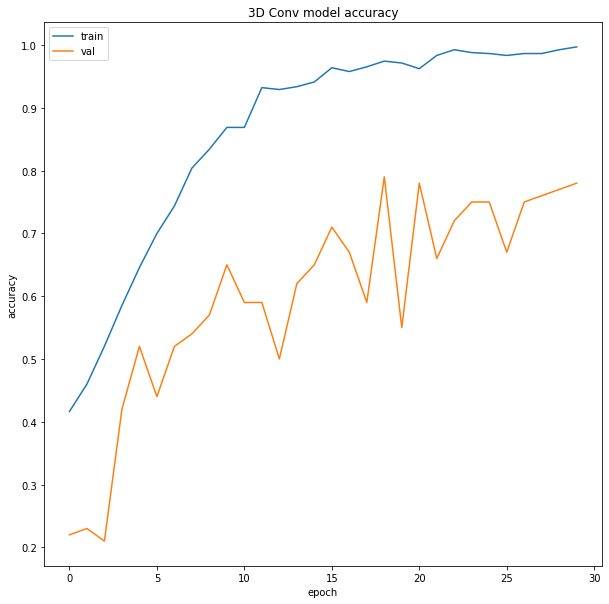

In [20]:
#Plotting the change in model accuracy on train and val sets
import matplotlib.pyplot as plt
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('3D Conv model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("3D model_accuracy.png")

## CNN + RNN (GRU)

In [20]:
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
Input_shape = (18,64,64,3)

modelGRU = Sequential()

modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=Input_shape))


modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
modelGRU.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
modelGRU.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
modelGRU.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelGRU.add(TimeDistributed(BatchNormalization()))
modelGRU.add(Dropout(0.25))

modelGRU.add(TimeDistributed(Flatten()))

modelGRU.add(Dense(nb_dense[0], activation='relu'))
modelGRU.add(Dropout(0.25))
modelGRU.add(Dense(nb_dense[1], activation='relu'))
modelGRU.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
modelGRU.add(GRU(128, return_sequences=False))
modelGRU.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
modelGRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelGRU.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_18 (TimeDi  (None, 18, 32, 32, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 18, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 18, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_21 (TimeDi  (None, 18, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_22 (TimeDi  (None, 18, 8, 8, 32)    

In [21]:
start = time.time()

history = modelGRU.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

end = time.time()

print("Total time taken for GRU training: ", "{:.2f}".format((end-start)), " secs")

Source path =  /home/datasets/Project_data/train ; batch size = 80
Epoch 1/30


2022-07-09 11:54:00.233325: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


9/9 [==============================] - ETA: 0s - loss: 1.5033 - categorical_accuracy: 0.3092Source path =  /home/datasets/Project_data/val ; batch size = 80

Epoch 00001: saving model to model_init_2022-07-0911_28_36.686044/model-00001-1.50326-0.30920-1.60413-0.23000.h5
9/9 [==============================] - 105s 12s/step - loss: 1.5033 - categorical_accuracy: 0.3092 - val_loss: 1.6041 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.2605 - categorical_accuracy: 0.4555 
Epoch 00002: saving model to model_init_2022-07-0911_28_36.686044/model-00002-1.26047-0.45551-1.65632-0.29000.h5
9/9 [==============================] - 92s 12s/step - loss: 1.2605 - categorical_accuracy: 0.4555 - val_loss: 1.6563 - val_categorical_accuracy: 0.2900 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.1324 - categorical_accuracy: 0.5400 
Epoch 00003: saving model to model_init_2022-07-0911_28_36.686044/model-000

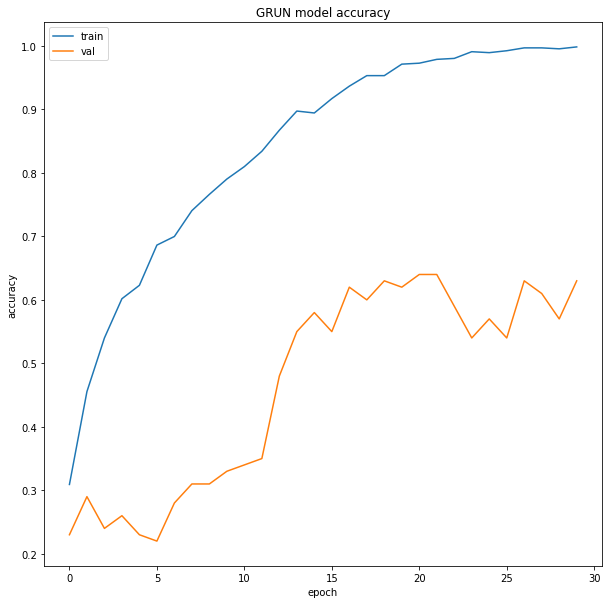

In [26]:
#Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('GRUN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("GRU model_accuracy.png")

## CNN+RNN(GRU) - Model 2

In [31]:
nb_featuremap = [8,16,32,64,128]
nb_dense = [128,64,5]
nb_classes = 5
Input_shape = (18,64,64,3)

modelGRU = Sequential()

modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=Input_shape))


modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
modelGRU.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
modelGRU.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
modelGRU.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelGRU.add(TimeDistributed(Conv2D(nb_featuremap[4], (2,2),padding='same', activation='relu')))
modelGRU.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelGRU.add(TimeDistributed(BatchNormalization()))
modelGRU.add(Dropout(0.25))

modelGRU.add(TimeDistributed(Flatten()))

modelGRU.add(Dense(nb_dense[0], activation='relu'))
modelGRU.add(Dropout(0.25))
modelGRU.add(Dense(nb_dense[1], activation='relu'))
modelGRU.add(Dropout(0.25))

## using 2 - GRU as the RNN model along with softmax as our last layer.
modelGRU.add(GRU(256, return_sequences=False))
modelGRU.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
modelGRU.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelGRU.summary())

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_60 (TimeDi  (None, 18, 32, 32, 8)    224       
 stributed)                                                      
                                                                 
 time_distributed_61 (TimeDi  (None, 18, 32, 32, 16)   1168      
 stributed)                                                      
                                                                 
 time_distributed_62 (TimeDi  (None, 18, 16, 16, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_63 (TimeDi  (None, 18, 16, 16, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_64 (TimeDi  (None, 18, 8, 8, 32)    

In [32]:
start = time.time()

history = modelGRU.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

end = time.time()

print("Total time taken for GRU - Model2 training: ", "{:.2f}".format((end-start)), " secs")

Epoch 1/30
9/9 [==============================] - ETA: 0s - loss: 1.4588 - categorical_accuracy: 0.3047
Epoch 00001: saving model to model_init_2022-07-0911_28_36.686044/model-00001-1.45880-0.30468-1.60425-0.23000.h5
9/9 [==============================] - 104s 13s/step - loss: 1.4588 - categorical_accuracy: 0.3047 - val_loss: 1.6042 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.2452 - categorical_accuracy: 0.4751
Epoch 00002: saving model to model_init_2022-07-0911_28_36.686044/model-00002-1.24517-0.47511-1.58943-0.23000.h5
9/9 [==============================] - 93s 12s/step - loss: 1.2452 - categorical_accuracy: 0.4751 - val_loss: 1.5894 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.1009 - categorical_accuracy: 0.5249
Epoch 00003: saving model to model_init_2022-07-0911_28_36.686044/model-00003-1.10089-0.52489-1.59841-0.27000.h5
9/9 [=============

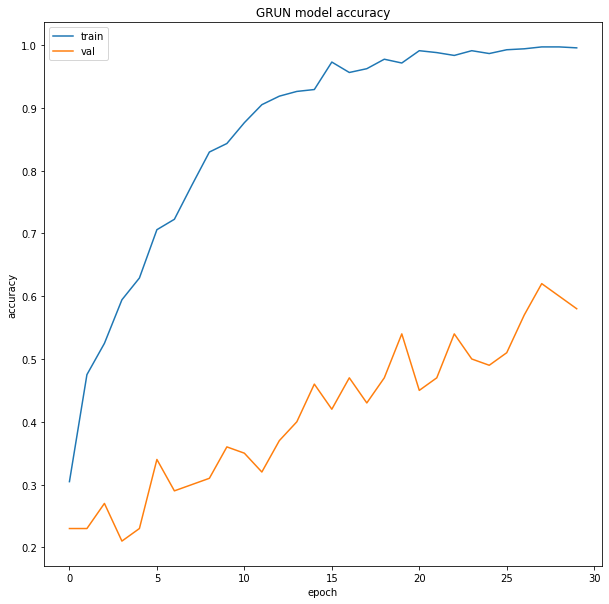

In [33]:
#Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('GRUN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("GRU model_accuracy.png")

## CNN + RNN (LSTM)

In [15]:
nb_featuremap = [8,16,32,64]
nb_dense = [128,64,5]
nb_classes = 5
Input_shape = (18,64,64,3)

modelLSTM = Sequential()

modelLSTM.add(TimeDistributed(Conv2D(nb_featuremap[0], (3, 3), strides=(2, 2),activation='relu', padding='same'), input_shape=Input_shape))


modelLSTM.add(TimeDistributed(Conv2D(nb_featuremap[1], (3,3),padding='same', activation='relu')))
modelLSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelLSTM.add(TimeDistributed(Conv2D(nb_featuremap[2], (3,3),padding='same', activation='relu')))
modelLSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelLSTM.add(TimeDistributed(Conv2D(nb_featuremap[3], (2,2),padding='same', activation='relu')))
modelLSTM.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

modelLSTM.add(TimeDistributed(BatchNormalization()))
modelLSTM.add(Dropout(0.25))

modelLSTM.add(TimeDistributed(Flatten()))

modelLSTM.add(Dense(nb_dense[0], activation='relu'))
modelLSTM.add(Dropout(0.25))
modelLSTM.add(Dense(nb_dense[1], activation='relu'))
modelLSTM.add(Dropout(0.25))

## using GRU as the RNN model along with softmax as our last layer.
modelLSTM.add(LSTM(128, return_sequences=False))
modelLSTM.add(Dense(nb_classes, activation='softmax')) # using Softmax as last layer
modelLSTM.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (modelLSTM.summary())

2022-07-09 13:58:36.397989: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-07-09 13:58:36.398050: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:1d:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 18, 32, 32, 8)    224       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 18, 32, 32, 16)   1168      
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 18, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 18, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 18, 8, 8, 32)     0

In [16]:
start = time.time()

history = modelLSTM.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

end = time.time()

print("Total time taken for LSTM training: ", "{:.2f}".format((end-start)), " secs")

Source path =  /home/datasets/Project_data/train ; batch size = 80
Epoch 1/30


2022-07-09 13:58:53.785188: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


9/9 [==============================] - ETA: 0s - loss: 1.4676 - categorical_accuracy: 0.3002Source path =  /home/datasets/Project_data/val ; batch size = 80

Epoch 00001: saving model to model_init_2022-07-0913_58_14.877633/model-00001-1.46759-0.30015-1.64621-0.23000.h5
9/9 [==============================] - 107s 13s/step - loss: 1.4676 - categorical_accuracy: 0.3002 - val_loss: 1.6462 - val_categorical_accuracy: 0.2300 - lr: 0.0010
Epoch 2/30
9/9 [==============================] - ETA: 0s - loss: 1.2513 - categorical_accuracy: 0.4872 
Epoch 00002: saving model to model_init_2022-07-0913_58_14.877633/model-00002-1.25134-0.48718-1.65392-0.27000.h5
9/9 [==============================] - 93s 12s/step - loss: 1.2513 - categorical_accuracy: 0.4872 - val_loss: 1.6539 - val_categorical_accuracy: 0.2700 - lr: 0.0010
Epoch 3/30
9/9 [==============================] - ETA: 0s - loss: 1.1015 - categorical_accuracy: 0.5249
Epoch 00003: saving model to model_init_2022-07-0913_58_14.877633/model-0000

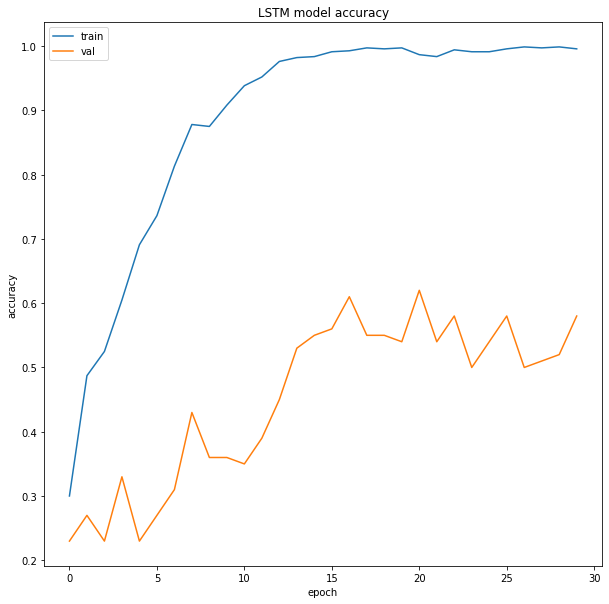

In [17]:
#Plotting the change in model accuracy on train and val sets
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('LSTM model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM model_accuracy.png")